# Agent Based Model for COVID-19

This notebook is a quick overview of our code used for simulation outbreaks and epidemics on specific spatial regions using the characteristics of COVID-19 and SARS-CoV-2 transmission.

If you're running this on **google colab**, make sure to adapt the code. This version was built to run on a local computer to optmize the parallelization computing, which is performed by the ```mpi4py``` library.

In [2]:
import numpy as np #simple math concepts and functions
import scipy.stats as st #statistics
import pandas as pd #data management
from numba import njit #code optmization
from random import choices #random numbers
from mpi4py import MPI #parallelization
import datetime #time
import os #folder management
import matplotlib.pyplot as plt #graphs

In [ ]:
# Here we set the environment for parallelization
com = MPI.COMM_WORLD

rank = com.rank

Before we begin our simulations, we need to set some parameters such as the proportion of asymptomatic individuals, the total number of individuals, the range of mobility for those individuals, etc.

We set the asymptomatic fraction as 0.3. That is, each infected agent has a 30% chance of not developing symptoms. This value was choosen based on the national serological survailance in Spain ([Pollán, M. et al. (2020)](https://doi.org/10.1016/S0140-6736(20)31483-5)), which suggested that around a third of individuals who had SARS-CoV-2 antibodies were asymptomatic. However, this estimate is susceptible to cofounders such as age, since children have higher chances of being asymptomatic than elders (see [He, J. et al. (2021)](https://doi.org/10.1002/jmv.26326)).

In [4]:
# Some constants and parameters of the model
asym = 0.3 #Fraction of asymptomatics
ident_A = 3 #Identifier for asymptomatic
ident_I = 2 #Identifier for symptomatic
ident_E = 1 #Identifier for exposed (presymptomatic)
ident_S = 0 #Indentifier for susceptible
ident_R = -1 #Identifier for recovered
ident_D = -2 #Identifier for dead
country = 'Brazil' #Selected country age structure
threshold = 0.5 # infection area
dt = 8/24 # time passage per iteration (in days, so if dt=1, each iteration is equivalent to one day)
xmin = -20 # lower bound of the area in the x direction
xmax = 20 # upper bound of the area in the x direction
ymin = -20 # lower bound of the area in the y direction
ymax = 20 # upper bound of the area in the y direction
xiso = 5 # increment in area for the quarantine region
F = np.array([0, 0]) # Strengh of attractors
attractor_position = np.array([[10,-10],
                              [-10,10]]).T
I0 = 5 #Initial number of infected symptomatic
F_infec = np.array([0, 0])
sig_infec = 5
attractor_infec_position = np.array([[9,9],
                                    [-9,-9]]).T
noiseness = 20 #Number of repetitions per configuration

individuals = [250,500,750,1000,1250] #List with all populations to run
mob = [1,3] #List with all mobilities to run
sigs = [4] #List with all sigmas
strenghs = [2] #List with all strenghs for the attractor

resolution = len(mob)

We next select the age pyramid structure desired for our simulation. In here, we provide the age pyramids of 7 countries: Brazil, Italy, Germany, Japan, South Africa, United States and Vietnam. That way we can simulate populations with low or high percentage of elders.

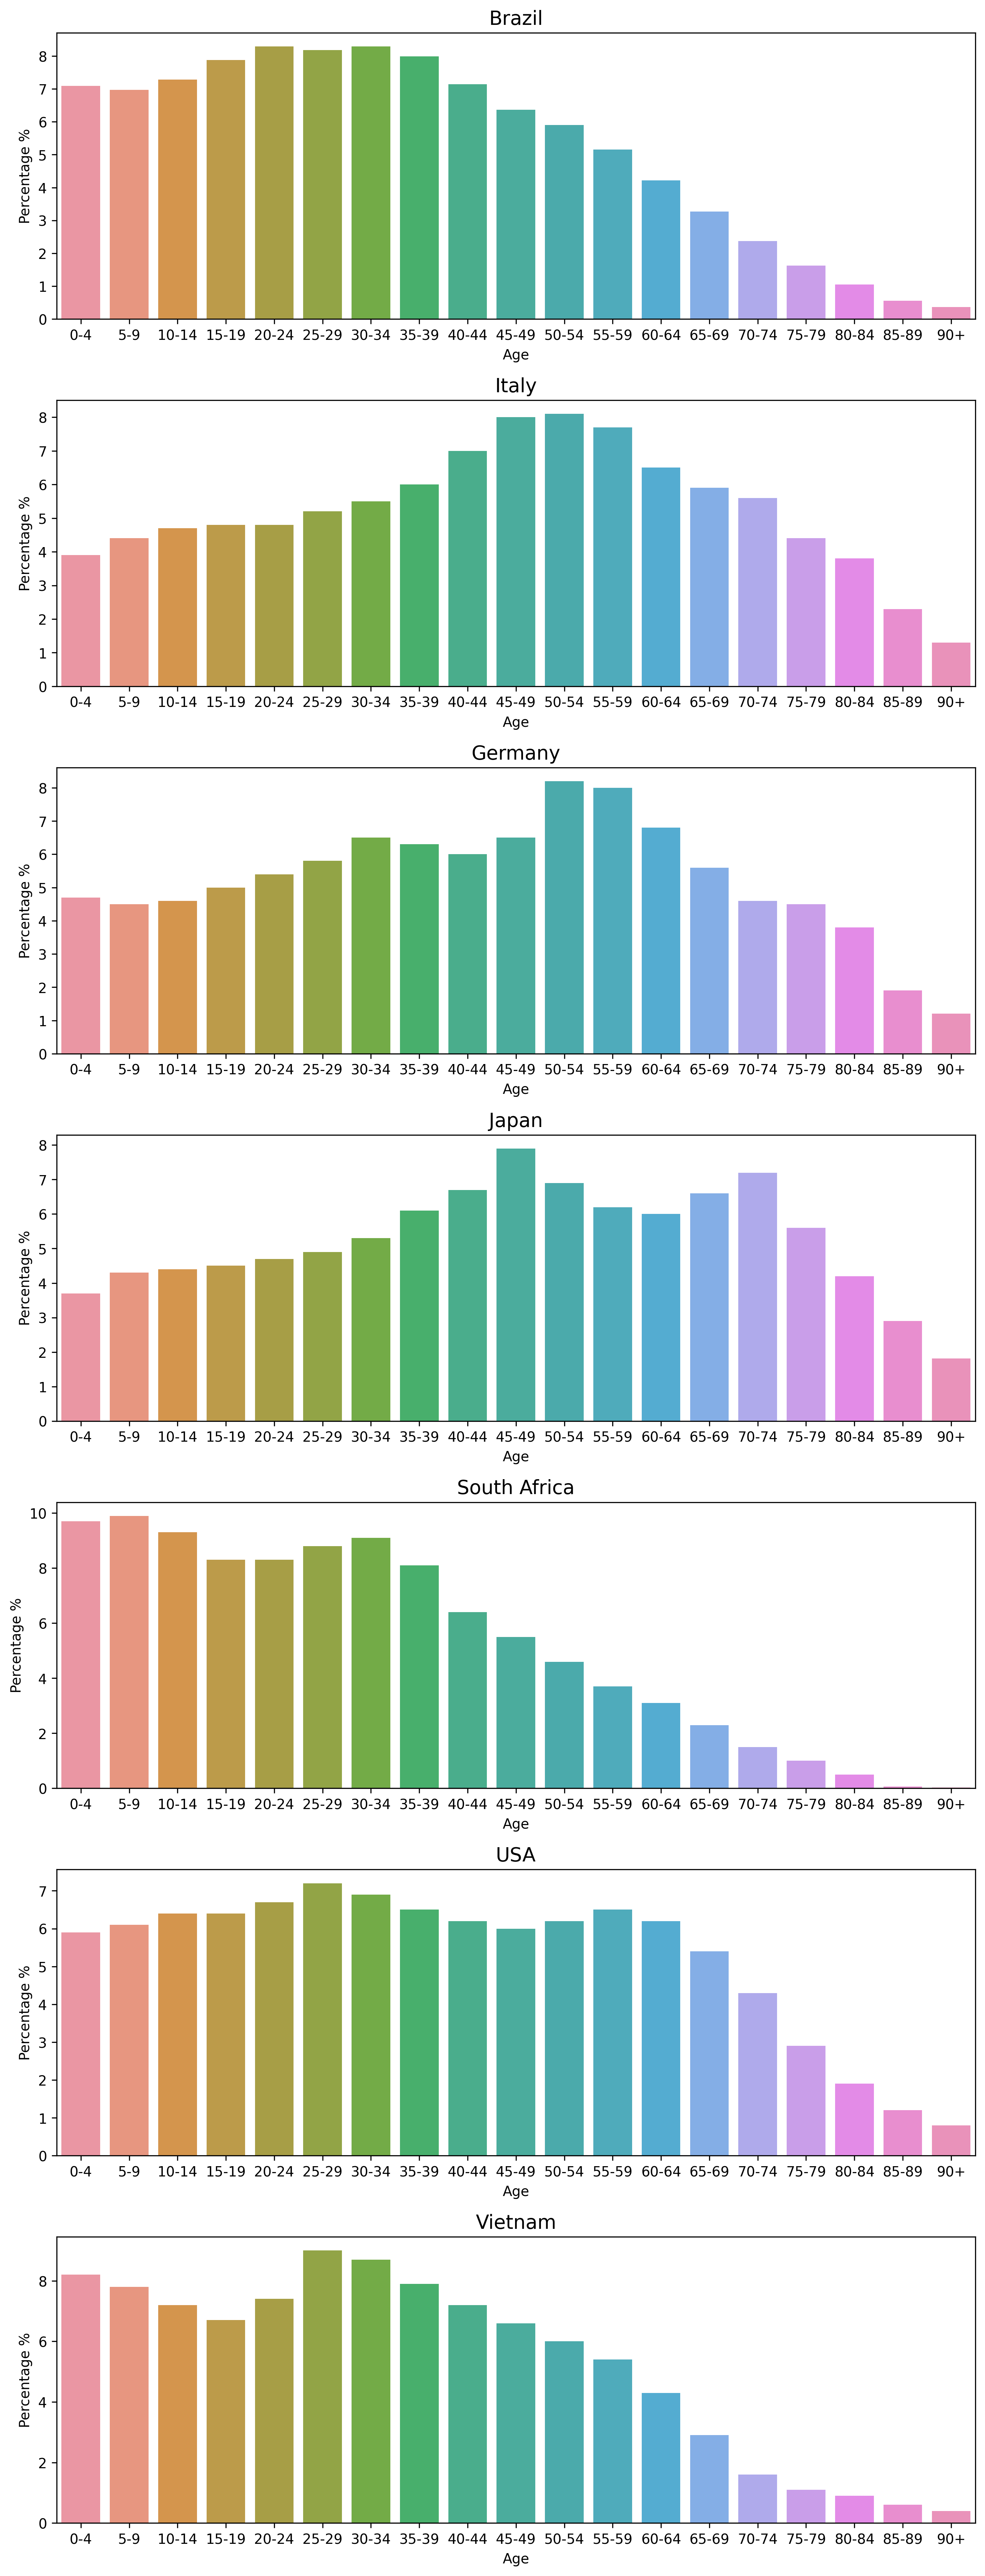

In [6]:
# Defining the age pyramid of Brazil, Italy, Germany, Japan, South Africa, USA and Vietnam
ages = pd.DataFrame({'Age': ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39',
                             '40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79',
                             '80-84','85-89','90+'],
                     'Percent Brazil': [7.09,6.97,7.28,7.88,8.29,8.18,8.29,7.99,7.14,6.37,5.90,5.16,
                                        4.22,3.27,2.37,1.62,1.05,0.56,0.36],
                     'Percent Italy': [3.9, 4.4, 4.7, 4.8, 4.8, 5.2, 5.5, 6, 7, 8, 8.1, 7.7, 6.5, 5.9,
                                 5.6, 4.4, 3.8, 2.3, 1.3],
                     'Percent Germany': [4.7, 4.5, 4.6, 5, 5.4, 5.8, 6.5, 6.3, 6, 6.5, 8.2, 8, 6.8, 5.6,
                                      4.6, 4.5, 3.8, 1.9, 0.9+0.25+0.05],
                     'Percent Japan': [3.7, 4.3, 4.4, 4.5, 4.7, 4.9, 5.3, 6.1, 6.7, 7.9, 6.9, 6.2, 6,
                                      6.6, 7.2, 5.6, 4.2, 2.9, 1.4+0.35+0.06],
                     'Percent South Africa': [9.7, 9.9, 9.3, 8.3, 8.3, 8.8, 9.1, 8.1, 6.4, 5.5, 4.6, 3.7, 3.1,
                                      2.3, 1.5, 1, 0.5, 0.07, 0.03+0+0],
                     'Percent USA': [5.9, 6.1, 6.4, 6.4, 6.7, 7.2, 6.9, 6.5, 6.2, 6, 6.2, 6.5, 6.2, 5.4,
                                      4.3, 2.9, 1.9, 1.2, 0.6+0.15+0.05],
                     'Percent Vietnam': [8.2, 7.8, 7.2, 6.7, 7.4, 9, 8.7, 7.9, 7.2, 6.6, 6, 5.4, 4.3, 2.9,
                                      1.6, 1.1, 0.9, 0.6, 0.3+0.1+0]})

population = [2,7,12,17,22,27,32,37,42,47,52,57,62,67,72,77,82,87,95]
weights = ages[f'Percent {country}']/np.sum(ages[f'Percent {country}'])

Now we build the primary functions for running the model. The first, is a function to update the agents velocity vector according to the potential well that attracts them. The second is the function that iterates through all agents and decides who is infected and who is not as well as updates their states.

If you want to optimize the code, add ```@njit``` on top of every function, for example:
```python
@njit
def SDE_int(x, x0, F, d, x0_infec, F_infec):
  ...
```
**Warning:** ```numba``` library is not compatible with some basic functions of python, if you are going to use it for code optmization, make sure to check the supported features with your current version of ```numba``` at [https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html)

In [ ]:
def SDE_int(x, x0, F, d, x0_infec, F_infec):
    """
    This function updates the agents velocities based on their distance to the
    attractor.
    Variables:
    x - matrix of agents and their characteristics
    x0 - coordinates of the center of the attractive potential well
    F - Strengh (depth) of each potential well
    d - Standard deviation of potential well (sigma of the gaussian)
    x0_infec - coordinates of the center of the attractive potential exclusive for
    symptomatic agents
    F_infec - Strengh of each potential well exclusive for symptomatic agents

    NOTE: If you want to take into account the presence of a different attractor
    exclusively to symptomatic patients, uncoment the last for loop and the sums
    on the last two lines
    """
    dv_all = np.zeros((2,n_people))
    dv = np.random.normal(0, d, (2,x[3:,np.where(x[0] != ident_I)[0]].shape[1]))*np.sqrt(dt) - 0.2*x[3:,np.where(x[0] != ident_I)[0]] #Random array of velocities for all non symptomatic
    dv_infec = np.random.normal(0, d, (2,x[3:,np.where(x[0] == ident_I)[0]].shape[1]))*np.sqrt(dt) - 0.2*x[3:,np.where(x[0] == ident_I)[0]] #Random array of velocities for all symptomatic
    for i in range(len(F)):
      #Here we add an attractive a increment dv in all agents that are not symptomatic according to the attractive well
        dv -= F[i]*(x[1:3,np.where(x[0] != ident_I)[0]]-x0[:,i:i+1])*np.exp(-(np.sum((x[1:3,np.where(x[0] != ident_I)[0]]-x0[:,i:i+1])**2, axis = 0))/(2*sig**2))*dt
    for j in range(len(F_infec)):
      #Same thing for symptomatic agents
        dv_infec -= F_infec[j]*(x[1:3,np.where(x[0] == ident_I)[0]]-x0_infec[:,j:j+1])*np.exp(-(np.sum((x[1:3,np.where(x[0] == ident_I)[0]]-x0_infec[:,j:j+1])**2, axis = 0))/(2*sig_infec**2))*dt
        dv += F_infec[j]*(x[1:3,np.where(x[0] != ident_I)[0]]-x0_infec[:,j:j+1])*np.exp(-(np.sum((x[1:3,np.where(x[0] != ident_I)[0]]-x0_infec[:,j:j+1])**2, axis = 0))/(2*sig_infec**2))*dt
#     for k in range(n_people):
#         dv_all[:,k] = np.sum(np.sign(x[1:3,k:k+1] - x[1:3,[i != k for i in range(n_people)]])*np.exp(-((x[1:3,k:k+1]-x[1:3,[i != k for i in range(n_people)]])**2)/(2 * 0.5**2)), axis = 1)
    
    dx = x[3:]*dt
    x[3:,np.where(x[0] != ident_I)[0]] = x[3:,np.where(x[0] != ident_I)[0]] + dv# + dv_all[:,np.where(x[0] != ident_I)[0]]
    x[3:,np.where(x[0] == ident_I)[0]] = x[3:,np.where(x[0] == ident_I)[0]] + dv_infec# + dv_all[:,np.where(x[0] == ident_I)[0]]
    return np.concatenate((x[0:1], x[1:3] + dx, x[3:]))

The next function is pretty big, here is an overview of what it does

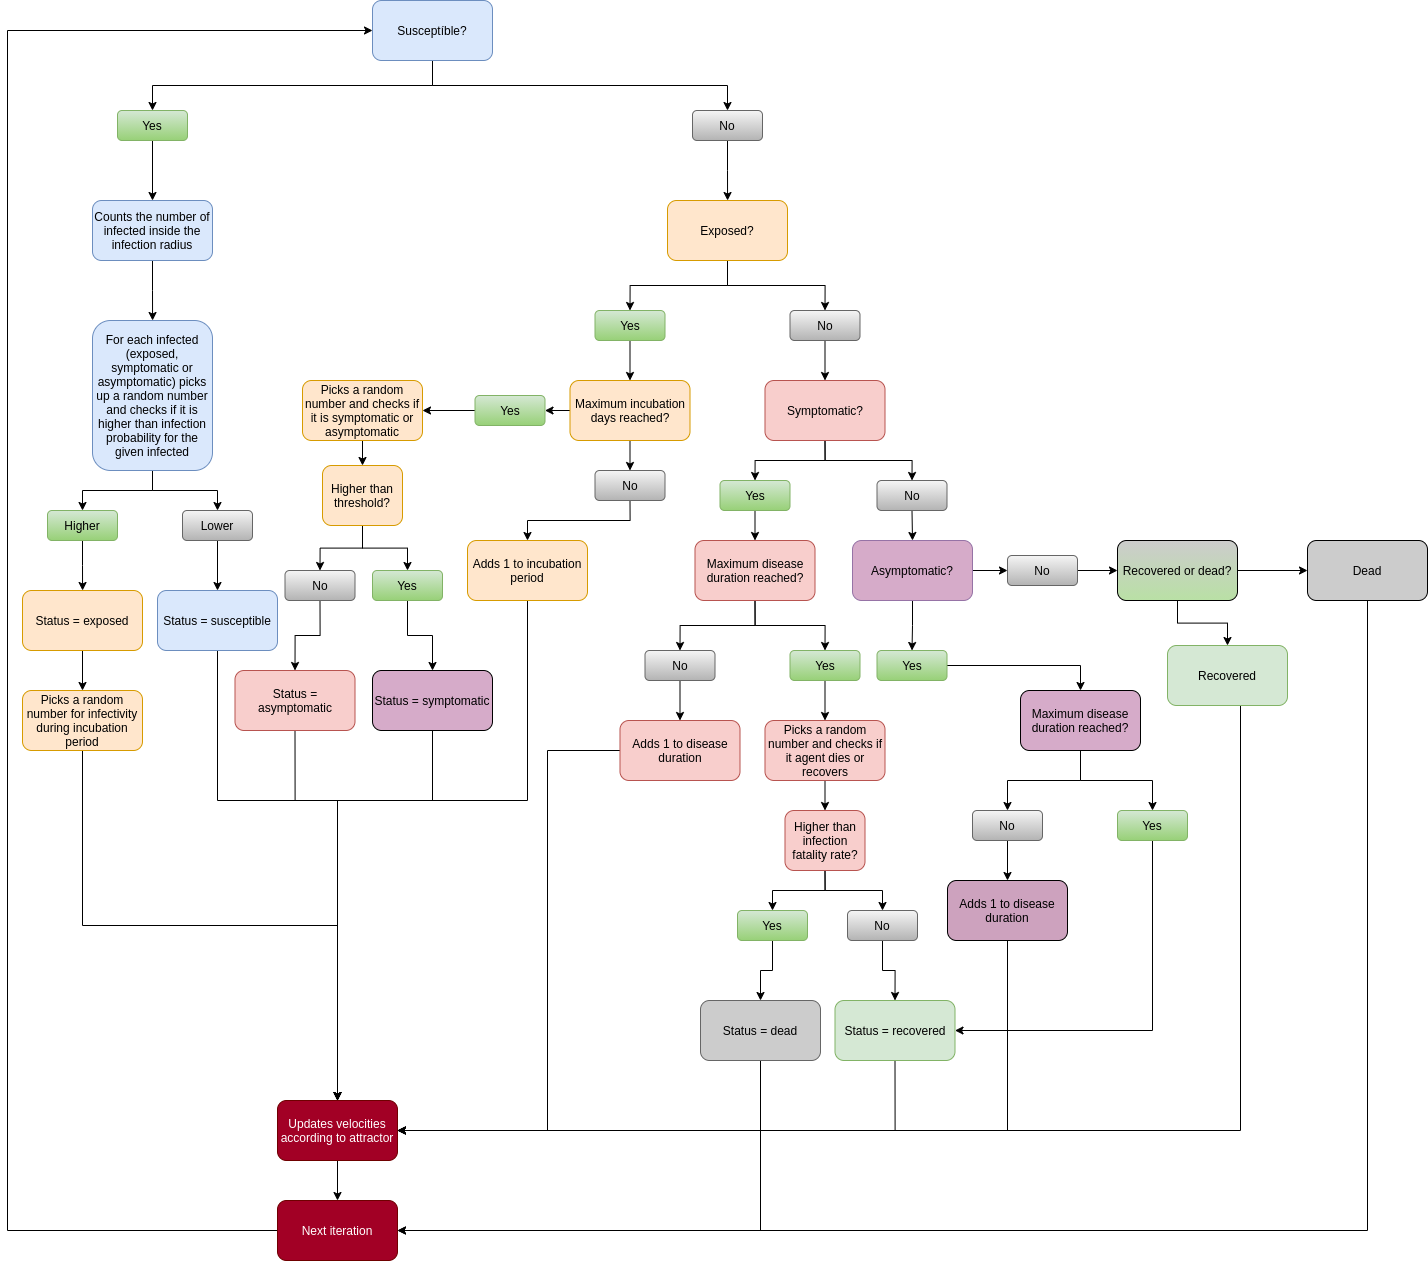

I'll leave some comments on it to help further understanding

In [ ]:
def agent_based_model(matrix, n_people, threshold, F, d, xmax, xmin, ymax, ymin, xiso, n_infecs, cumulatives, attractor_position, S, I, R):
  """
  This function iterates through all agents and do all updating necessary. First
  it checks if a susceptible agent is going to be infected or not, if it is infected,
  it becomes an exposed agent and the distance from the infection point to the attractor
  center is saved. Also, a infectivity is randomly assigned to that agent.
  Then it moves to check the status of each agent and update their recovery/death/incubation
  times
  """
    positions_infec = []
    for j in range(n_people):
        infec_total = np.sum(n_infecs)
        # Check in the susceptible agent is going to be infected or not
        if matrix[0,j] == 0:
            inf_neib = np.where(np.sqrt(np.sum((matrix[1:3,np.where(matrix[0] == ident_I)[0]] - matrix[1:3,j:j+1])**2,
                                                   axis = 0)) <= threshold)[0]
            exp_neib = np.where(np.sqrt(np.sum((matrix[1:3,np.where(matrix[0] == ident_E)[0]] - matrix[1:3,j:j+1])**2,
                                                   axis = 0)) <= threshold)[0]
            asym_neib = np.where(np.sqrt(np.sum((matrix[1:3,np.where(matrix[0] == ident_A)[0]] - matrix[1:3,j:j+1])**2,
                                                   axis = 0)) <= threshold)[0]
            for i in range(len(inf_neib)):
            # Checks if the susceptible agent is infected by the symptomatics around it
                if np.random.uniform(0, 1) <= matrix[8,inf_neib[i]]:
                    matrix[0,j] = ident_E
                    matrix[7,j] = 1
                    dist = min([np.linalg.norm(matrix[1:3,j] - k) for k in attractor_position])
                    positions_infec.append(dist) # Saves the distance from infection point to closest attractor
                    # Picks a random infectivity for the agent
                    if np.sum(n_infecs) == infec_total:
                        n_infecs[1] += 1
                    matrix[8,j] = np.random.gamma(0.65, 0.2)
                    while matrix[8,j] > 1:
                        matrix[8,j] = np.random.gamma(0.65, 0.2)
            # Checks if the susceptible agent is infected by the presymptomatics around it
            for i in range(len(exp_neib)):
                if np.random.uniform(0, 1) <= matrix[8,exp_neib[i]]:
                    matrix[0,j] = ident_E
                    matrix[7,j] = 1
                    dist = min([np.linalg.norm(matrix[1:3,j] - k) for k in attractor_position])
                    positions_infec.append(dist) # Saves the distance from infection point to closest attractor
                    if np.sum(n_infecs) == infec_total:
                        n_infecs[0] += 1
                    matrix[8,j] = np.random.gamma(0.65, 0.2)
                    while matrix[8,j] > 1:
                        matrix[8,j] = np.random.gamma(0.65, 0.2)
            # Checks if the susceptible agent is infected by the asymptomatics around it
            for i in range(len(asym_neib)):
                if np.random.uniform(0, 1) <= matrix[8,asym_neib[i]]:
                    matrix[0,j] = ident_E
                    matrix[7,j] = 1
                    dist = min([np.linalg.norm(matrix[1:3,j] - k) for k in attractor_position])
                    positions_infec.append(dist) # Saves the distance from infection point to closest attractor
                    if np.sum(n_infecs) == infec_total:
                        n_infecs[2] += 1
                    matrix[8,j] = np.random.gamma(0.65, 0.2)
                    while matrix[8,j] > 1:
                        matrix[8,j] = np.random.gamma(0.65, 0.2)
                        
        # Check status of agents with conditions and update either characteristic times of agent status
        if 0 < matrix[6,j] < matrix[11,j]:
            matrix[6,j] += 1
        elif matrix[6,j] == matrix[11,j]:
            if matrix[0,j] != ident_R:
                cumulatives[2] += 1
            matrix[0,j] = ident_R # Change status to recovered
        elif 0 < matrix[5,j] < matrix[10,j]:
            matrix[5,j] += 1
        elif matrix[5,j] == matrix[10,j]:
            if matrix[0,j] != ident_D:
                cumulatives[3] += 1
            matrix[0,j] = ident_D # Change status to dead
            matrix[3:5,j] = 0
        elif 0 < matrix[7,j] < matrix[9,j]:
            matrix[7,j] += 1
        elif matrix[7,j] == matrix[9,j]:
            if np.random.uniform(0,1) <= asym:
                matrix[0,j] = ident_A # Change status to asymptomatic
                matrix[6,j] = 1
                cumulatives[1] += 1
            else:
                matrix[0,j] = ident_I # Change status to symptomatic
                cumulatives[0] += 1
                if np.random.uniform(0,1) <= matrix[13,j]:
                    matrix[5,j] = 1
                else:
                    matrix[6,j] = 1
                # Picks anothe random number for a new infectivity, higher than the one during the incubation period
                matrix[8,j] = np.random.gamma(1.3, 0.2)
                while matrix[8,j] > 1:
                    matrix[8,j] = np.random.gamma(1.3, 0.2)
                # If the agent is tested positive, it is placed in quarantine
                if np.random.uniform(0,1) <= 0.98:
                    matrix[1,j] = xmax + xiso/2
        # Boundary condition to make sure agents in quarantine don't leave quarantine
        if matrix[0,j] == ident_I:
            matrix[3] *= np.sign(matrix[1]+xmax+xiso)
            matrix[3] *= -np.sign(matrix[1]+xmin+xiso)
            if np.abs(matrix[1,j]) < xmax:
                matrix[1,j] = np.random.uniform(xmax,xiso)
        else:
            if np.abs(matrix[1,j]) > xmax:
                matrix[1,j] = np.random.uniform(-20,20)
            if np.abs(matrix[2,j]) > ymax:
                matrix[2,j] = np.random.uniform(-20,20)
    # Updates velocities and positions according to attractor and random walk
    matrix[:5] = SDE_int(matrix[:5], attractor_position, F, d, attractor_infec_position, F_infec)
    # Boundaries
    matrix[3] *= np.sign(matrix[1]+xmax)
    matrix[3] *= -np.sign(matrix[1]+xmin)
    matrix[4] *= np.sign(matrix[2]+xmax)
    matrix[4] *= -np.sign(matrix[2]+xmin)
    return matrix[0,:], positions_infec, n_infecs, cumulatives

The model is ready to run, before running, we build our variables where we will be saving out metrics. We save the following values:

- Final attack rate
- Final death rate
- Time for simulation
- Distances from infections to attractor (that serves as a benchmark that the attractor is working)
- Proportion of cases caused by symptomatic, asymptomatic and presymptomatic agents
- Epidemic curves (infected, exposed, recovered, asymptomatic)

In [ ]:
distances_real_oficial_infecs = {}
results_infec_mean = {}
results_infec_std = {}
results_death_mean = {}
results_death_std = {}
total_time = {}
total_time_std = {}
results_infec_mean['N people'] = individuals
results_infec_std['N people'] = individuals
results_death_mean['N people'] = individuals
results_death_std['N people'] = individuals
total_time['N people'] = individuals
total_time_std['N people'] = individuals

In [ ]:
# The identifier of the folders for the results is the current datetime
datetime_now = str(datetime.datetime.now()).split(".")[0].replace(" ", "_").replace(":","-")

In [ ]:
# Here we create the folders where everything will be saved
if rank == 0:
    main = f'results_{datetime_now}'
    sub_mean = 'mean'
    sub_std = 'std'
    main_infec = 'infec'
    main_death = 'death'
    main_time = 'time'
    main_distances = 'distances'
    main_densities = 'density'
    os.mkdir(main)
    os.mkdir(main + '/' + main_infec)
    os.mkdir(main + '/' + main_death)
    os.mkdir(main + '/' + main_time)
    os.mkdir(main + '/' + main_distances)
    os.mkdir(main + '/' + main_densities)
    os.mkdir(main + '/' + main_infec + '/' + sub_mean)
    os.mkdir(main + '/' + main_infec + '/' + sub_std)
    os.mkdir(main + '/' + main_death + '/' + sub_mean)
    os.mkdir(main + '/' + main_death + '/' + sub_std)
    os.mkdir(main + '/' + main_time + '/' + sub_mean)
    os.mkdir(main + '/' + main_time + '/' + sub_std)
else:
    main = ""
    sub_mean = ""
    sub_std = ""
    main_infec = ""
    main_death = ""
    main_time = ""
    main_distances = ""
    main_densities = ""

In [ ]:
# Here we make sure that only one of the cores of the computer creates the folder, not all of them
main = com.bcast(main,0)
sub_mean = com.bcast(sub_mean,0)
sub_std = com.bcast(sub_std,0)
main_infec = com.bcast(main_infec,0)
main_death = com.bcast(main_death,0)
main_time = com.bcast(main_time,0)
main_distances = com.bcast(main_distances,0)
main_densities = com.bcast(main_densities,0)

Now we get to the loop that runs the final code. It iterates through all sigmas of attractor, than through all strenghs of attractor, than through all mobilities, than trough all populations and finally through all repetitions. Like this

```python
for each sigma:
  for each strengh:
    for each mobility:
      for each population:
        for each repetition:
          run model until number of infected = 0
          break
          save metrics
```

In [ ]:
# This is the loop that runs the final code. It iterates 

for q in range(len(sigs)): #Loop in all sigmas
    sig = sigs[q]
    for v in range(len(strenghs)): #Loop in all strenghs
        strengh = strenghs[v]
        F = np.array([strengh, strengh])
        for l in range(resolution): #Loop in all mobilities
            d= mob[l]
            # Here we define some empty arrays where we will store the final results
            Total_infections_mean = []
            Total_infections_std = []
            Total_infections_95_low = []
            Total_infections_95_up = []
            Total_deaths_mean = []
            Total_deaths_std = []
            Total_deaths_95_low = []
            Total_deaths_95_up = []
            people = []
            mobility = []
            time_mean = []
            time_std = []
            for m in range(len(individuals)): #Loop in all populations
                n_people = individuals[m]
                # Some more empty arrays for specific metrics
                S_final = []
                I_final = []
                E_final = []
                A_final = []
                R_final = []
                D_final = []
                I_final_tot = []
                A_final_tot = []
                D_final_tot = []
                time = []
                position_infec_tot = []
        
                for k in range(noiseness): #Loop for each repetition
                    # Creating the matrix of individuals and their characteristics
                    matrix = np.zeros((14,n_people))
                    matrix[0,:I0] = ident_I # Initial infected
                    matrix[1:3,:] = np.random.uniform(xmin, xmax, (2,n_people)) #initial positions
                    matrix[3:5,:] = 0 #initial velocities
                    matrix[8,:] = np.random.gamma(1.3, 0.2, n_people) #Infecvity
                    matrix[9,:] = np.round(np.random.lognormal(1.5, 0.6, n_people)/dt) # incubation periods
                    matrix[10,:] = np.round(np.random.lognormal(2.84, 0.58, n_people)/dt) # time to death
                    matrix[11,:] = np.round(np.random.gamma(2.2, 6.36, n_people)/dt) # time to recovery
                    matrix[12,:] = np.round(choices(population, weights, k = n_people)) # age
                    matrix[13,:] = 0.0000457*np.exp(0.08952*matrix[12,:])
                    for i in range(len(matrix[8,:])):
                        while matrix[8,i] > 1:
                            matrix[8,i] = np.random.gamma(1, 0.2, 1)
                    
                    for i in range(I0):
                        if np.random.uniform(0,1) <= matrix[13,i]:
                            matrix[5,i] = 1
                        else:
                            matrix[6,i] = 1
        
                    S = [n_people - I0]
                    E = [0]
                    I = [I0]
                    A = [0]
                    R = [0]
                    D = [0]
        
                    I_tot = I0
                    A_tot = 0
                    kt = 0
                    n_infecs = np.zeros((3))
                    cumulatives = np.zeros((4))
                    n_infecs_time = [n_infecs]
                    cumulatives_time = [[I0,0,0,0,0]]
                    while True:
                        kt += 1
                        matrix_piru, position_infec, n_infecs, cumulatives = agent_based_model(matrix, n_people, threshold, F, d, xmax, xmin, ymax, ymin, xiso, n_infecs, cumulatives, attractor_position, S, I, R)
                        position_infec_tot += position_infec
                        n_infecs_time.append(n_infecs)
                        S.append(len(np.where(matrix_piru[:] == 0)[0]))
                        E.append(len(np.where(matrix_piru[:] == ident_E)[0]))
                        I.append(len(np.where(matrix_piru[:] == ident_I)[0]))
                        A.append(len(np.where(matrix_piru[:] == ident_A)[0]))
                        R.append(len(np.where(matrix_piru[:] == ident_R)[0]))
                        D.append(len(np.where(matrix_piru[:] == ident_D)[0]))
                        cumulatives_time.append([I[-1],E[-1],A[-1],R[-1],D[-1]])

#### IF YOU WANT TO SAVE THE PLOTS, UNCOMENT THIS SECTION AND SELECT A FOLDER TO SAVE THE PLOT OF EACH ITERATION
#                        fig, ax = plt.subplots(2,1, figsize=(6,8))
#                        ax[0].scatter(*matrix[1:3,matrix[0] == ident_S], color = 'blue', s = 10)
#                        ax[0].scatter(*matrix[1:3,matrix[0] == ident_E], color = 'orange', s = 10)
#                        ax[0].scatter(*matrix[1:3,matrix[0] == ident_I], color = 'red', s = 10)
#                        ax[0].scatter(*matrix[1:3,matrix[0] == ident_A], color = 'purple', s = 10)
#                        ax[0].scatter(*matrix[1:3,matrix[0] == ident_R], color = 'green', s = 10)
#                        ax[0].scatter(*matrix[1:3,matrix[0] == ident_D], color = 'black', s = 10)
#                        ax[0].set_title(f'Pop: {n_people}, Strengh: {strengh}, Mobility: {d}'
#                          '\n'
#                          f'Fraction of infections by: expo {n_infecs[0]/np.sum(n_infecs):.2f}, symp {n_infecs[1]/np.sum(n_infecs):.2f} & asymp {n_infecs[2]/np.sum(n_infecs):.2f}'
#                          '\n'
#                          f'Total infections: {np.sum(n_infecs)}')
#                        ax[0].set_xlim(xmin,xmax+xiso)
#                        ax[0].set_ylim(ymin,ymax)
#                        ax[0].vlines(xmax, ymin, ymax)
#                        ax[0].set_xlabel(f'Symp: {cumulatives[0]}, Asymp: {cumulatives[1]}, Recov: {cumulatives[2]}, Dead: {cumulatives[3]}')
#                        ax[1].plot(S, lw= 2, color = 'blue', label = 'Susceptible')
#                        ax[1].plot(E, lw= 2, color = 'orange', label = 'Presymptomatic')
#                        ax[1].plot(I, lw= 2, color = 'red', label = 'Symptomatic')
#                        ax[1].plot(A, lw= 2, color = 'purple', label = 'Asymptomatic')
#                        ax[1].plot(R, lw= 2, color = 'green', label = 'Recovered')
#                        ax[1].plot(D, lw= 2, color = 'black', label = 'Dead')
#                        ax[1].set_ylim(0, 1000)
#                        ax[1].set_xlim(0, 350)
#                        ax[1].legend(loc='upper right', fontsize = 12)
#                        plt.tight_layout()
#                        plt.savefig(f'Test_pop{n_people}_mob{d}_force{strengh}_{kt}.png')
#                        ax[0].cla()
#                        ax[1].cla()
#                        plt.show()
        
                        if I[-1] == 0 and E[-1] == 0 and A[-1] == 0:
                            S_final.append(S)
                            I_final.append(I)
                            E_final.append(E)
                            A_final.append(A)
                            R_final.append(R)
                            D_final.append(D)
                            D_final_tot.append(D[-1])
                            I_final_tot.append(R[-1]+D[-1])
                            time.append(kt)
        
                            break
                    # Saving metrics
                    np.savetxt(f'{main}/{main_densities}/cumulatives_{strengh}_sig_{sig}_noise_{noiseness}_mob_{d}_pop_{individuals[m]}_run_{k}_rank_{rank}_brazil_pyramid.txt', cumulatives_time)
                    np.savetxt(f'{main}/{main_densities}/n_infecs_{strengh}_sig_{sig}_noise_{noiseness}_mob_{d}_pop_{individuals[m]}_run_{k}_rank_{rank}_brazil_pyramid.txt', n_infecs)
                distances_real_oficial_infecs[f'Pop: {n_people} Mob: {d}'] = pd.Series(position_infec_tot)
                I_final_tot = np.array(I_final_tot)
                Total_infections_mean.append(np.mean(I_final_tot)/n_people)
                Total_infections_std.append(np.std(I_final_tot)/n_people)
                Total_deaths_mean.append(np.mean(D_final_tot)/n_people)
                Total_deaths_std.append(np.std(D_final_tot)/n_people)
                people.append(n_people)
                time_mean.append(np.mean(time))
                time_std.append(np.std(time))

            mobility.append(d)
            results_infec_mean[f'{d}'] = Total_infections_mean
            results_infec_std[f'{d}'] = Total_infections_std
            results_death_mean[f'{d}'] = Total_deaths_mean
            results_death_std[f'{d}'] = Total_deaths_std
            total_time[f'{d}'] = time_mean
            total_time_std[f'{d}'] = time_std

            pd.DataFrame(distances_real_oficial_infecs).to_csv(f'{main}/{main_distances}/distances_to_attracs_brazil_pyramid_strength_{strengh}_sig{sig}.csv')
            pd.DataFrame(results_infec_mean).to_csv(f'{main}/{main_infec}/{sub_mean}/infec_mean_age_{noiseness}_times_attractor_{strengh}_sig_{sig}_rank_{rank}_brazil_pyramid.csv')
            pd.DataFrame(results_infec_std).to_csv(f'{main}/{main_infec}/{sub_std}/infec_std_age_{noiseness}_times_attractor_{strengh}_sig_{sig}_rank_{rank}_brazil_pyramid.csv')
            pd.DataFrame(results_death_mean).to_csv(f'{main}/{main_death}/{sub_mean}/death_mean_age_{noiseness}_times_attractor_{strengh}_sig_{sig}_rank_{rank}_brazil_pyramid.csv')
            pd.DataFrame(results_death_std).to_csv(f'{main}/{main_death}/{sub_std}/death_std_age_{noiseness}_times_attractor_{strengh}_sig_{sig}_rank_{rank}_brazil_pyramid.csv')
            pd.DataFrame(total_time).to_csv(f'{main}/{main_time}/{sub_mean}/time_mean_age_{noiseness}_times_attractor_{strengh}_sig_{sig}_rank_{rank}_brazil_pyramid.csv')
            pd.DataFrame(total_time_std).to_csv(f'{main}/{main_time}/{sub_std}/time_std_age_{noiseness}_times_attractor_{strengh}_sig_{sig}_rank_{rank}_brazil_pyramid.csv')

If you have any doubts, please contact:

**pedrohpc@ifi.unicamp.br**

or

**p235648@dac.unicamp.br**

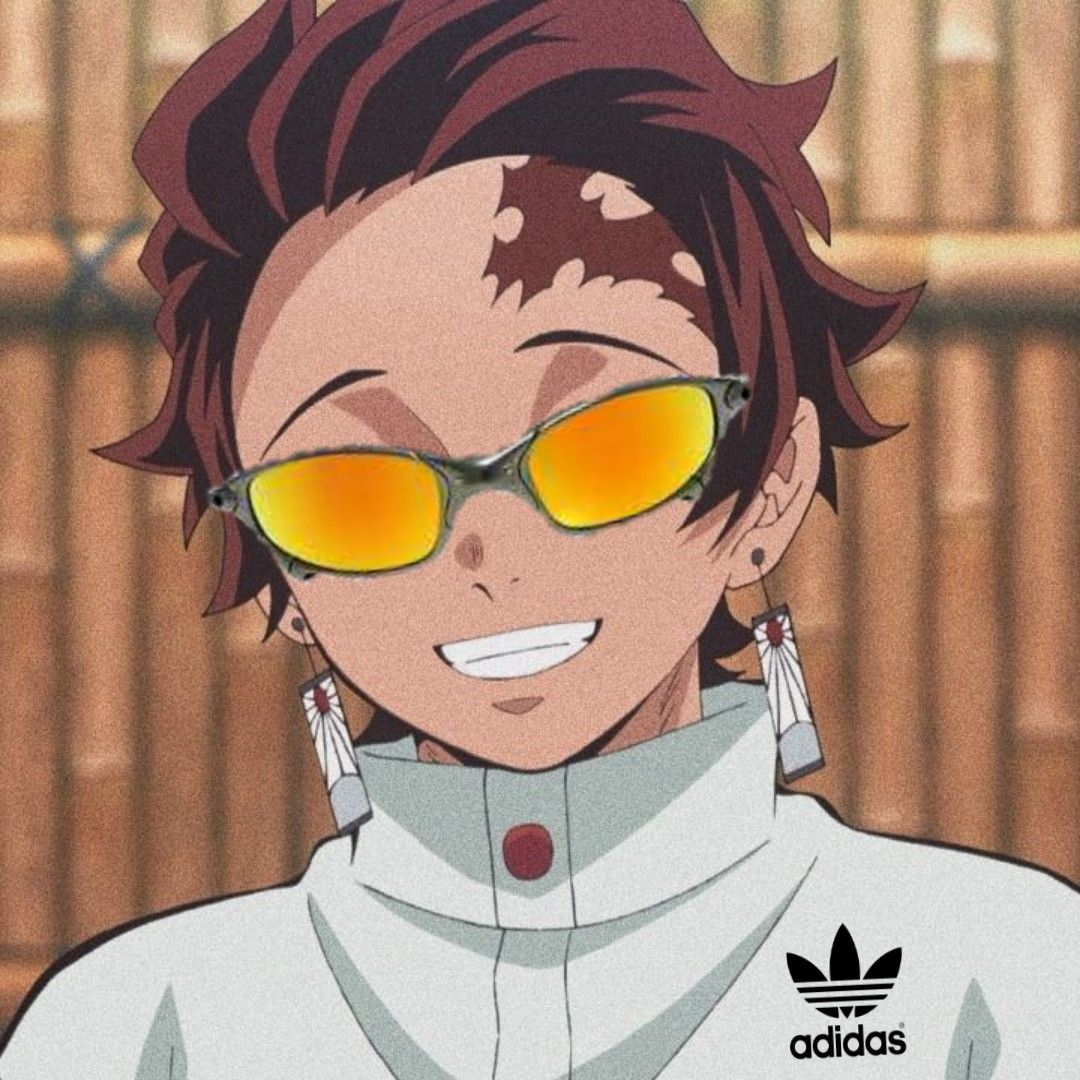